In [1]:
import os
import glob
from typing import Dict
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from py_utils import data_ops
from lib import misc

import main_fte

plt.style.use(os.path.join("../configs", "mplstyle.yaml"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# First load all labelled frames into a pandas dataframe.
gt_root_dir = "/Users/zico/msc/data/gt_labels"
labelled_files = sorted(glob.glob(os.path.join(gt_root_dir, "**/CollectedData_UCT.h5"), recursive=True))
vid = None
for curr_file in labelled_files:
    vid = curr_file.split(gt_root_dir + "/")[1]
    vid = vid.split("/")[0]
    # Assuming that cam1 indicates the start of a new video sequence (the videos are sorted above).
    cam_idx = int(vid[-1])
    if cam_idx == 1:
        out_dir = curr_file.split("cam1/CollectedData_UCT.h5")[0]
        os.makedirs(out_dir, exist_ok=True)
    try:
        curr_df = pd.read_hdf(curr_file)
    except ValueError:
        continue    
    start_frame = int(curr_df.index[0].split("img")[1][0:3])
    frame_index = range(start_frame, start_frame + len(curr_df.index))
    curr_df.index = frame_index
    curr_df.to_hdf(os.path.join(out_dir, f"cam{cam_idx}.h5"), "df_with_missing", format="table", mode="w")

In [ ]:
def load_dlc_points_as_df(df_fpaths):
    dfs = []
    cam_indices = []
    for path in df_fpaths:
        vid = path.split(".h5")[0]
        cam_indices.append(int(vid[-1]) - 1)
        dlc_df = pd.read_hdf(path)
        dlc_df = dlc_df.droplevel([0], axis=1).swaplevel(0,1,axis=1).T.unstack().T.reset_index().rename({'level_0':'frame'}, axis=1)
        dlc_df.columns.name = ''
        dfs.append(dlc_df)
    #create new dataframe
    dlc_df = pd.DataFrame(columns=['frame', 'camera', 'marker', 'x', 'y'])
    for i, df in enumerate(dfs):
        df['camera'] = cam_indices[i]
        df.rename(columns={'bodyparts':'marker'}, inplace=True)
        dlc_df = pd.concat([dlc_df, df], sort=True, ignore_index=True)

    dlc_df = dlc_df[['frame', 'camera', 'marker', 'x', 'y']]
    return dlc_df

In [ ]:
dlc_dirs = ("/Users/zico/msc/data/gt_labels/2019_03_09LilyFlick", "/Users/zico/msc/data/gt_labels/2019_03_09JulesFlick2", "/Users/zico/msc/data/gt_labels/2017_12_16PhantomFlick2_1", "/Users/zico/msc/data/gt_labels/2017_09_03ZorroFlick1_1")
for dlc_file in dlc_dirs:
    dlc_fpaths = sorted(glob.glob(os.path.join(dlc_file, "*.h5")))
    res_df = load_dlc_points_as_df(dlc_fpaths)
    df = pd.DataFrame(res_df)
    ret_name = dlc_file.split("/")[-1]
    print(f"Saving...{ret_name}")
    df.to_csv(os.path.join(dlc_file, f"{ret_name}.csv"))

In [ ]:
root_results_dir = "/Users/zico/msc/data/PairwiseExperimentResults3"
burst_lengths = (1, 5, 10, 15)
num_drop_outs = (0, 25, 50, 75, 90)
drop_out_range = (15, 105)

# Generate dataset of the manually dropped measurements.
drop_out_dataset = {}
for burst in burst_lengths:
    for num_filtered in num_drop_outs:
        drop_out_frames = []
        if num_filtered == 0 or num_filtered == 90:
            continue
        elif burst == 1:
             # Randomly select unique frames to drop out.
            drop_out_frames = random.sample(range(*drop_out_range), num_filtered)
        else:
            # Manullay select uniform bursts.
            num_bursts = np.ceil(num_filtered / burst)
            burst_gaps = np.ceil((drop_out_range[1] - drop_out_range[0]) / num_bursts)
            filtered_frames = np.asarray([range(i, i + burst) for i in range(*drop_out_range, int(burst_gaps))]).flatten()
            gen_diff = len(filtered_frames) - num_filtered
            drop_out_frames = filtered_frames[:-gen_diff] if gen_diff > 0 else filtered_frames

        print(f"({burst}, {num_filtered}): {len(drop_out_frames)}")
        assert len(drop_out_frames) == len(set(drop_out_frames)) and len(drop_out_frames) == num_filtered
        drop_out_dataset[(burst, num_filtered)] = drop_out_frames

drop_out_dataset[(1, 0)] = []
drop_out_dataset[(1, 90)] = list(range(*drop_out_range))
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in drop_out_dataset.items()]), columns=list(drop_out_dataset.keys()))
df.to_csv(os.path.join(root_results_dir, "manual_drop_outs.csv"))

In [ ]:
drop_out_dataset = pd.read_csv(os.path.join(root_results_dir, "manual_drop_outs.csv"))
tup = (1, 0)
drop_out_dataset[str(tup)].values

In [ ]:
root_dir = os.path.join("/Users/zico/OneDrive - University of Cape Town/CheetahReconstructionResults/cheetah_videos")
root_results_dir = "/Users/zico/msc/data/PairwiseExperimentResults3"
burst_lengths = (1, 5, 10, 15)
num_drop_outs = (0, 25, 50, 75, 90)
drop_out_range = (15, 105)
data_path = os.path.join("2017_08_29", "top", "jules", "run1_1")
start_frame = 10
end_frame = 110
dlc_thresh = 0.5

# tests = ("Normal", "Pairwise")
tests = ("Pairwise")
filtered_markers = ("r_front_ankle", "r_front_paw", "r_back_ankle", "r_back_paw")
drop_out_dataset = pd.read_csv(os.path.join(root_results_dir, "manual_drop_outs.csv"))
for test in tests:
    for burst in burst_lengths:
        for num_filtered in num_drop_outs:
            out_prefix = os.path.join(root_results_dir, test, f"{num_filtered}_percent_{burst}_burst")
            try:
                drop_out_frames = list(drop_out_dataset[str((burst, num_filtered))].values)
            except KeyError:
                continue
            print(f"Run test: {out_prefix}")
            # Run the optimisation
            main_fte.run(root_dir, data_path, start_frame, end_frame, dlc_thresh, filtered_markers = filtered_markers, drop_out_frames = drop_out_frames,  pairwise_included = 2 if test == "Pairwise" else 0, out_dir_prefix=out_prefix)
            # Produce results
            _, _ = main_fte.metrics(root_dir, data_path, start_frame, end_frame, dlc_thresh, out_dir_prefix=out_prefix)

Text(0.5, 0.98, 'Average Reprojection Error')

Text(0.5, 1.0, 'Burst Length [frames]: 1')

Text(0.5, 1.0, 'Burst Length [frames]: 5')

Text(0.5, 1.0, 'Burst Length [frames]: 10')

Text(0.5, 1.0, 'Burst Length [frames]: 15')

Text(0.5, 0.007, 'Percentage of Measurements Dropped')

Text(0.007, 0.5, 'Error [px]')

Text(0.5, 0.98, 'Removed Marker Average Reprojection Error')

Text(0.5, 1.0, 'Burst Length [frames]: 1')

Text(0.5, 1.0, 'Burst Length [frames]: 5')

Text(0.5, 1.0, 'Burst Length [frames]: 10')

Text(0.5, 1.0, 'Burst Length [frames]: 15')

Text(0.5, 0.007, 'Percentage of Measurements Dropped')

Text(0.007, 0.5, 'Error [px]')

/Users/zico/opt/anaconda3/envs/pypy/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: print_svg() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)
/Users/zico/opt/anaconda3/envs/pypy/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


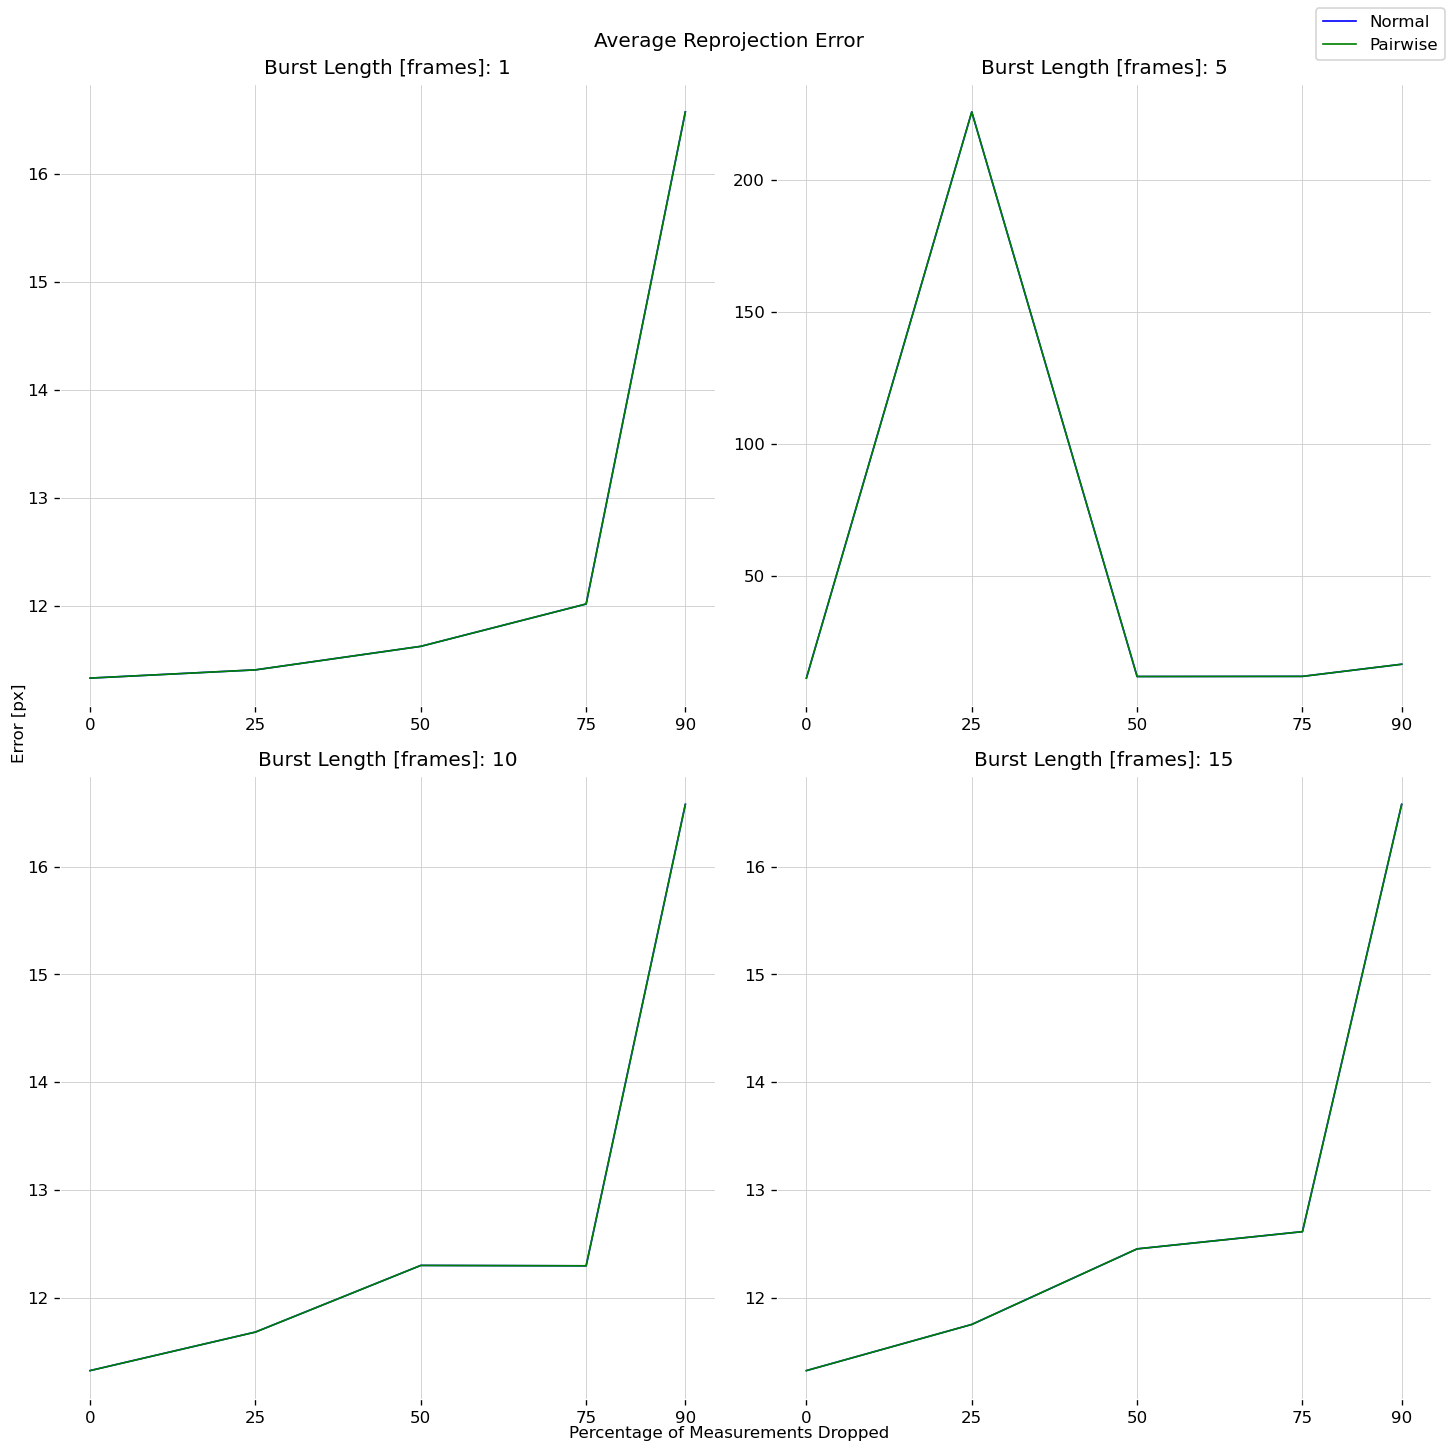

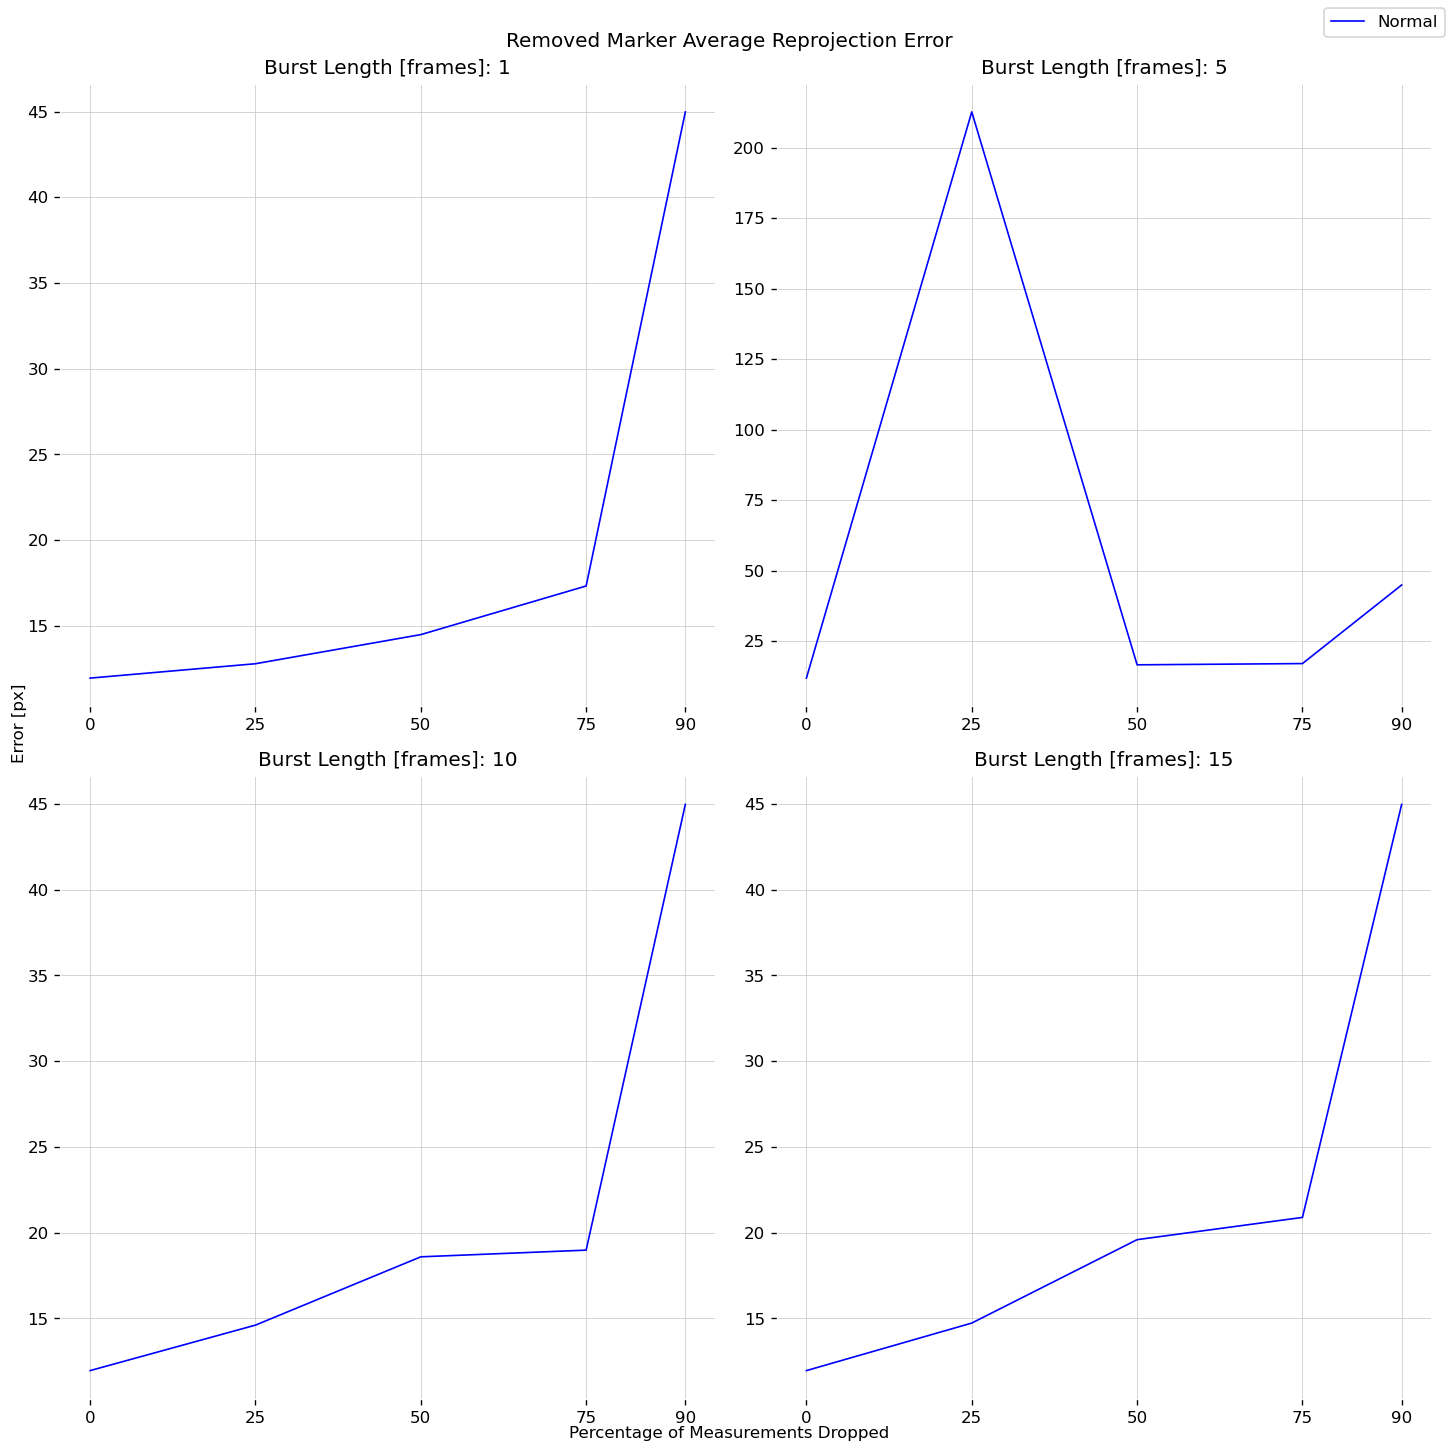

In [3]:
root_results_dir = "/Users/zico/msc/data/PairwiseExperimentResults3"
test_run_dir = "2017_08_29/top/jules/run1_1/fte_pw"
normal_dir = os.path.join(root_results_dir, "Normal")
pw_dir = os.path.join(root_results_dir, "Pairwise")

removed_markers = ("r_front_ankle", "r_front_paw", "r_back_ankle", "r_back_paw")
burst_lengths = (1, 5, 10, 15)
num_drop_outs = (0, 25, 50, 75, 90)
drop_out_dataset = pd.read_csv(os.path.join(root_results_dir, "manual_drop_outs.csv"))
valid_tests = drop_out_dataset.columns.values
plots = {}
for burst in burst_lengths:
    plots[burst] = [[], []]
    for num_filtered in num_drop_outs:
        burst_ = burst
        if str((burst, num_filtered)) not in valid_tests:
            burst_ = 1
        for i, test_type in enumerate((normal_dir, pw_dir)):
            test_dir = os.path.join(test_type, f"{num_filtered}_percent_{burst_}_burst")
            meas = pd.read_csv(os.path.join(test_dir, test_run_dir, "measurement_results.csv"))
            errors = pd.read_csv(os.path.join(test_dir, test_run_dir, "reprojection_results.csv"))
            errors["# meas [%]"] = meas.iloc[0, 1:].values
            data = errors.rename(columns={ "Unnamed: 0": "marker"})
            data = data[["marker", "mean", "std", "# meas [%]"]]
            avg_limb_data = data.loc[data["marker"].isin(removed_markers)]
            avg_limb_data = avg_limb_data.mean()
            avg_data = data.mean()
            plots[burst][i].append([*avg_data.values, *avg_limb_data.values])


fig = plt.figure(figsize=(12, 12), dpi=120)
fig.suptitle("Average Reprojection Error")
for i, burst_plot in enumerate(plots.keys()):
    plotting_data = np.asarray(plots[burst_plot])
    ax = fig.add_subplot(2, 2, i+1)
    plot_data = ax.plot(num_drop_outs, plotting_data[0, :, 0], "b")
    plot_data += ax.plot(num_drop_outs, plotting_data[1, :, 0], "g")
    ax.set_xticks(num_drop_outs)
    ax.set_title(f"Burst Length [frames]: {burst_plot}")

fig.legend(plot_data, ("Normal", "Pairwise"), loc="upper right")
fig.text(0.5, 0.007, "Percentage of Measurements Dropped", ha='center', va='center')
fig.text(0.007, 0.5, "Error [px]", ha='center', va='center', rotation='vertical')
fig.savefig(os.path.join(root_results_dir, "avg_error.pdf"))

fig = plt.figure(figsize=(12, 12), dpi=120)
fig.suptitle("Removed Marker Average Reprojection Error")
for i, burst_plot in enumerate(plots.keys()):
    plotting_data = np.asarray(plots[burst_plot])
    ax = fig.add_subplot(2, 2, i+1)
    plot_data = ax.plot(num_drop_outs, plotting_data[0, :, 3], "b")
    plot_data += ax.plot(num_drop_outs, plotting_data[1, :, 3], "g")
    ax.set_xticks(num_drop_outs)
    ax.set_title(f"Burst Length [frames]: {burst_plot}")

fig.legend(plot_data, ("Normal", "Pairwise"), loc="upper right")
fig.text(0.5, 0.007, "Percentage of Measurements Dropped", ha='center', va='center')
fig.text(0.007, 0.5, "Error [px]", ha='center', va='center', rotation='vertical')
fig.savefig(os.path.join(root_results_dir, "removed_marker_avg_error.pdf"))

# ax = fig.add_subplot(3, 2, 3)
# ax.plot(tests, plots[0, :, 1], "b")
# ax.plot(tests, plots[1, :, 1], "g")
# ax.set_title("Reprojection Error Std Dev (Overall)")
# ax.set_xticks(tests)
# ax.set_ylabel("Error [px]")

# ax = fig.add_subplot(3, 2, 5)
# plot_data = ax.plot(tests, plots[0, :, 2], "b")
# plot_data += ax.plot(tests, plots[1, :, 2], "g")
# ax.set_title("Percentage of Measurements Included (Overall)")
# ax.set_xticks(tests)
# ax.set_ylabel("Percentage")


# ax = fig.add_subplot(3, 2, 2)
# ax.plot(tests, plots[0, :, 3], "b")
# ax.plot(tests, plots[1, :, 3], "g")
# ax.set_title("Reprojection Error Mean (Limbs)")
# ax.set_xticks(tests)
# ax.set_ylabel("Error [px]")

# ax = fig.add_subplot(3, 2, 4)
# ax.plot(tests, plots[0, :, 4], "b")
# ax.plot(tests, plots[1, :, 4], "g")
# ax.set_title("Reprojection Error Std Dev (Limbs)")
# ax.set_xticks(tests)
# ax.set_ylabel("Error [px]")

# ax = fig.add_subplot(3, 2, 6)
# plot_data = ax.plot(tests, plots[0, :, 5], "b")
# plot_data += ax.plot(tests, plots[1, :, 5], "g")
# ax.set_title("Percentage of Measurements Included (Limbs)")
# ax.set_xticks(tests)
# ax.set_ylabel("Percentage")